# First attempt for training model

----

In this code, we'll try to train a model so it can correctly diagnose cancer in input images

## Prerequisites

We'll first configure the logging options an imports

In [1]:
# => fails, necessary on Fedora 27, ipython3 6.2.1
%config Application.log_level='INFO'

import logging

logging.basicConfig(level=logging.INFO)

# Get the root logger and set its level
logger = logging.getLogger()
logger.setLevel(logging.INFO)

In [2]:
from src.handlers import Handler, TciaHandler, OpHandler

import torch
from torch.utils.tensorboard import SummaryWriter
import numpy as np
import seaborn as sns
# from torch.utils.tensorboard import SummaryWriter
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

%matplotlib inline

In [3]:
# from monai.apps import download_and_extract
from monai.config import print_config
from monai.data import decollate_batch, DataLoader, CacheDataset, pad_list_data_collate
from monai.metrics import ROCAUCMetric
from monai.networks.nets import DenseNet121
from monai.transforms import (
    Activations,
    EnsureChannelFirst,
    AsDiscrete,
    Compose,
    LoadImage,
    RandFlip,
    RandRotate,
    RandZoom,
    ScaleIntensity,
    LoadImaged,
    EnsureChannelFirstd,
    Orientationd,
    ScaleIntensityRanged
)
# from monai.utils import set_determinism


/home/studio-lab-user/.conda/envs/monai-conda/lib/python3.12/site-packages/ignite/handlers/checkpoint.py:17: DeprecationWarning: `TorchScript` support for functional optimizers is deprecated and will be removed in a future PyTorch release. Consider using the `torch.compile` optimizer instead.
  from torch.distributed.optim import ZeroRedundancyOptimizer


### Variable configuration

make sure to provide here all the needed information for file locations

In [4]:
BASE_PATH = 'Data/'
# ...
TCIA_IMG_SUFFIX = '_PV.nii.gz'
TCIA_LOCATION = BASE_PATH + 'TCIA/'
TCIA_EXCEL_NAME = 'HCC-TACE-Seg_clinical_data-V2.xlsx'
# ...
OP_LOCATION = BASE_PATH + 'OP/'
NIFTI_PATH = 'OP_C+P_nifti'
NNU_NET_PATH = 'OP_C+P_nnUnet'
OP_EXCEL = 'OP_申請建模_1121110_20231223.xlsx'
OP_IMG_SUFFIX = '_VENOUS_PHASE.nii.gz'
OP_MASK_SUFFIX = '_VENOUS_PHASE_seg.nii.gz'
OP_ID_COL_NAME = 'OP_C+P_Tumor識別碼'


## File preparation

In this step we're gonna read the excel files and extract the filepaths

In [5]:
global_handler = Handler()

#TODO: add TCIA files
# tcia = TciaHandler(TCIA_LOCATION, TCIA_IMG_SUFFIX, TCIA_EXCEL_NAME)
# global_handler.add_source(tcia)

op = OpHandler(OP_LOCATION, NIFTI_PATH, NNU_NET_PATH, OP_IMG_SUFFIX, OP_MASK_SUFFIX, OP_EXCEL, OP_ID_COL_NAME)
global_handler.add_source(op)

DEBUG:src.handlers:reading file Data/OP/OP_申請建模_1121110_20231223.xlsx
INFO:src.handlers:200 rows in the excel file
INFO:src.handlers:Removed 55 stage-d elements
DEBUG:src.handlers:Classifying...
DEBUG:src.handlers:Looking for paths against contents
DEBUG:src.handlers:Searching for mismatch on files vs excel data...
DEBUG:src.handlers:Returning new dataframe
The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
DEBUG:src.handlers:None


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145 entries, 0 to 144
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   class   145 non-null    float64
 1   img     145 non-null    object 
 2   mask    145 non-null    object 
dtypes: float64(1), object(2)
memory usage: 3.5+ KB


### Data exploration

here it comes a bit of data exploration. You might ommit these steps

In [6]:
df = global_handler.df

df.head()

,class,img,mask
0,0.0,Data/OP/OP_C+P_nifti/OP_0067_VENOUS_PHASE.nii.gz,Data/OP/OP_C+P_nnUnet/OP_0067_VENOUS_PHASE_seg...
1,0.0,Data/OP/OP_C+P_nifti/OP_0068_VENOUS_PHASE.nii.gz,Data/OP/OP_C+P_nnUnet/OP_0068_VENOUS_PHASE_seg...
2,1.0,Data/OP/OP_C+P_nifti/OP_0069_VENOUS_PHASE.nii.gz,Data/OP/OP_C+P_nnUnet/OP_0069_VENOUS_PHASE_seg...
3,0.0,Data/OP/OP_C+P_nifti/OP_0070_VENOUS_PHASE.nii.gz,Data/OP/OP_C+P_nnUnet/OP_0070_VENOUS_PHASE_seg...
4,1.0,Data/OP/OP_C+P_nifti/OP_0071_VENOUS_PHASE.nii.gz,Data/OP/OP_C+P_nnUnet/OP_0071_VENOUS_PHASE_seg...


INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


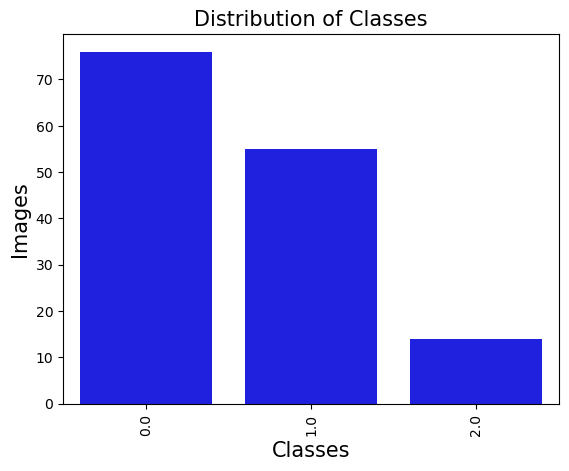

In [7]:
dist = df['class'].value_counts()

sns.barplot(x=dist.index, y=dist.values, color='b')
plt.title('Distribution of Classes', fontsize=15)
plt.xlabel('Classes', fontsize=15)
plt.ylabel('Images', fontsize=15)
plt.xticks(rotation=90)
plt.show()

In [8]:
X_train, X_test, y_train, y_test  = train_test_split(
    df[['img', 'mask']],
    df['class'],
    shuffle=True,
    test_size=0.4,
    random_state=8,
    stratify=df['class']
)

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


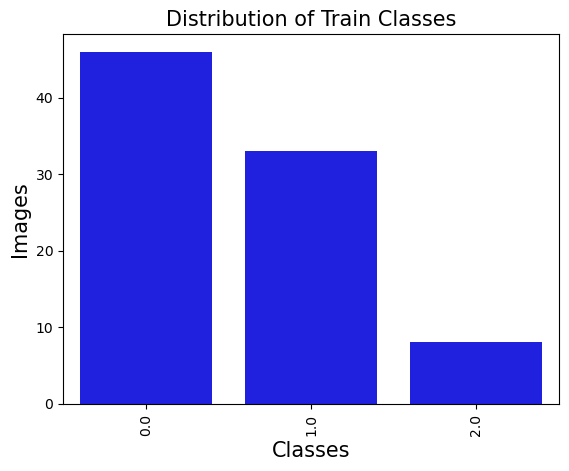

In [9]:
dist = y_train.value_counts()
class_num = len(dist)
sns.barplot(x=dist.index, y=dist.values, color='b')
plt.title('Distribution of Train Classes', fontsize=15)
plt.xlabel('Classes', fontsize=15)
plt.ylabel('Images', fontsize=15)
plt.xticks(rotation=90)
plt.show()

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


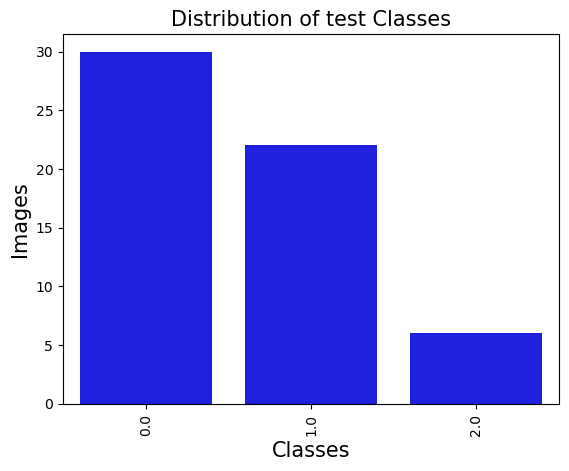

In [10]:
dist = y_test.value_counts()

sns.barplot(x=dist.index, y=dist.values, color='b')
plt.title('Distribution of test Classes', fontsize=15)
plt.xlabel('Classes', fontsize=15)
plt.ylabel('Images', fontsize=15)
plt.xticks(rotation=90)
plt.show()

In [11]:
len(y_test) + len(y_train)

145

## Model training

Now we might start with the fun part!

### Meta information

Info and config for monai libraries

In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

device

device(type='cuda')

In [13]:
print_config()

MONAI version: 1.3.2
Numpy version: 1.26.4
Pytorch version: 2.4.0+cu121
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: 59a7211070538586369afd4a01eca0a7fe2e742e
MONAI __file__: /home/<username>/.conda/envs/monai-conda/lib/python3.12/site-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: 0.4.11
ITK version: 5.4.0
Nibabel version: 5.2.1
scikit-image version: 0.24.0
scipy version: 1.14.1
Pillow version: 10.4.0
Tensorboard version: 2.17.0
gdown version: 5.2.0
TorchVision version: 0.19.0+cu121
tqdm version: 4.66.4
lmdb version: 1.5.1
psutil version: 6.0.0
pandas version: 2.2.2
einops version: 0.8.0
transformers version: NOT INSTALLED or UNKNOWN VERSION.
mlflow version: 2.15.0
pynrrd version: 1.0.0
clearml version: 1.16.3rc2

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



In [14]:
!nvidia-smi

Wed Aug 28 11:27:03 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.183.01             Driver Version: 535.183.01   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:1E.0 Off |                    0 |
| N/A   34C    P0              26W /  70W |      5MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

### Monai objects

Config of transformations, dataset and dataloader

In [15]:
# TODO: use the train/test split

raw_ds = df.head().to_dict(orient='records')

ds_keys = list(raw_ds[0].keys())[-2:]

raw_ds

[{'class': 0.0,
  'img': 'Data/OP/OP_C+P_nifti/OP_0067_VENOUS_PHASE.nii.gz',
  'mask': 'Data/OP/OP_C+P_nnUnet/OP_0067_VENOUS_PHASE_seg.nii.gz'},
 {'class': 0.0,
  'img': 'Data/OP/OP_C+P_nifti/OP_0068_VENOUS_PHASE.nii.gz',
  'mask': 'Data/OP/OP_C+P_nnUnet/OP_0068_VENOUS_PHASE_seg.nii.gz'},
 {'class': 1.0,
  'img': 'Data/OP/OP_C+P_nifti/OP_0069_VENOUS_PHASE.nii.gz',
  'mask': 'Data/OP/OP_C+P_nnUnet/OP_0069_VENOUS_PHASE_seg.nii.gz'},
 {'class': 0.0,
  'img': 'Data/OP/OP_C+P_nifti/OP_0070_VENOUS_PHASE.nii.gz',
  'mask': 'Data/OP/OP_C+P_nnUnet/OP_0070_VENOUS_PHASE_seg.nii.gz'},
 {'class': 1.0,
  'img': 'Data/OP/OP_C+P_nifti/OP_0071_VENOUS_PHASE.nii.gz',
  'mask': 'Data/OP/OP_C+P_nnUnet/OP_0071_VENOUS_PHASE_seg.nii.gz'}]

In [16]:
train_transforms = Compose([
    LoadImaged(keys=ds_keys),
    EnsureChannelFirstd(keys=ds_keys),
    Orientationd(keys=ds_keys, axcodes="PLI"),
    # transforms.SpatialPadd(keys=["PVimg", "PVmask"], spatial_size=(512, 512, 128), method='symmetric', mode='constant'),
    # transforms.Resized(keys=["PVimg"], spatial_size=(512, 512, 128)),
    ScaleIntensityRanged(keys=[ds_keys[0]], a_min=-135, a_max=215, b_min=0.0, b_max=1.0, clip=True),
    # captureliverpart,
    # slicer_2D

])

In [17]:
train_ds = CacheDataset(
    data=raw_ds,
    transform=train_transforms,
    cache_rate=1.0,
    num_workers=1
)
train_loader = DataLoader(
    train_ds,
    batch_size=1,
    num_workers=1,
    pin_memory=torch.cuda.is_available(),
    collate_fn=pad_list_data_collate
)

Loading dataset: 100%|██████████| 5/5 [00:04<00:00,  1.24it/s]


### Model training

In [18]:
# temporal model import
from monai.networks.nets.densenet import densenet121
from torch.amp import GradScaler, autocast


In [19]:
model = densenet121(spatial_dims=3, in_channels=1, out_channels=3).to(device)
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), 1e-4)

# Mixed precision setup
scaler = GradScaler(device.type)


In [29]:
# Start typical PyTorch training
val_interval = 2
best_metric = -1
best_metric_epoch = -1
epoch_loss_values = []
metric_values = []
writer = SummaryWriter()
max_epochs = 5
accumulation_steps = 4  # Number of steps to accumulate gradients

from torch import cuda

cuda.empty_cache()

In [35]:
for epoch in range(max_epochs):
    print("-" * 10)
    print(f"epoch {epoch + 1}/{max_epochs}")
    model.train()
    epoch_loss = 0
    step = 0

    optimizer.zero_grad()
    
    for batch_data in train_loader:
        step += 1
        inputs, labels = batch_data[ds_keys[0]].to(device), batch_data["class"].to(device)
        
        with autocast(device.type):
            # For preventing an error of "not double implemented"
            inputs = inputs.float()
            labels = labels.long()
            
            outputs = model(inputs)
            loss = loss_function(outputs, labels)
        scaler.scale(loss).backward()
        
        if step % accumulation_steps == 0:
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()
        
        # Clear CUDA cache
        cuda.empty_cache()
        
        epoch_loss += loss.item()
        epoch_len = len(train_ds) // train_loader.batch_size
        print(f"{step}/{epoch_len}, train_loss: {loss.item():.4f}")
        writer.add_scalar("train_loss", loss.item(), epoch_len * epoch + step)
    # end for batch_data in train_loader
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")
    
    if (epoch + 1) % val_interval == 0:
        model.eval()
        
        num_correct = 0.0
        metric_count = 0
        
        with torch.no_grad():
            for val_data in test_loader:
                val_images, val_labels = val_data["PVimg"].to(device), val_data["label"].to(device)
            # end for in test_loader
        # end with torch.no_grad()
    # end if val_interval == 0
# end for epoch in range

----------
epoch 1/5
1/5, train_loss: 0.1643
2/5, train_loss: 0.1892
3/5, train_loss: 0.4958
4/5, train_loss: 0.1882
5/5, train_loss: 1.5518
epoch 1 average loss: 0.5179
----------
epoch 2/5
1/5, train_loss: 0.1558
2/5, train_loss: 0.1794
3/5, train_loss: 0.4692
4/5, train_loss: 0.1783
5/5, train_loss: 1.5537
epoch 2 average loss: 0.5073


NameError: name 'test_loader' is not defined

[IPKernelApp] Exception in execute request:
---------------------------------------------------------------------------
NameError                                 Traceback (most recent call last)
Cell In[35], line 47
     44         metric_count = 0
     46         with torch.no_grad():
---> 47             for val_data in test_loader:
     48                 val_images, val_labels = val_data["PVimg"].to(device), val_data["label"].to(device)
     49             # end for in test_loader
     50         # end with torch.no_grad()
     51     # end if val_interval == 0
     52 # end for epoch in range

NameError: name 'test_loader' is not defined
[IPKernelApp] Aborting queue
[IPKernelApp] Finishing abort


# Please ignore this

---

In [30]:
train_transforms = Compose(
    [
        LoadImage(image_only=True),
        EnsureChannelFirst(),
        ScaleIntensity(),
        RandRotate(range_x=np.pi / 12, prob=0.5, keep_size=True),
        RandFlip(spatial_axis=0, prob=0.5),
        RandZoom(min_zoom=0.9, max_zoom=1.1, prob=0.5),
    ]
)

val_transforms = Compose([LoadImage(image_only=True), EnsureChannelFirst(), ScaleIntensity()])

y_pred_trans = Compose([Activations(softmax=True)])
y_trans = Compose([AsDiscrete(to_onehot=class_num)])

In [33]:
class MedNISTDataset(torch.utils.data.Dataset):
    def __init__(self, image_files, labels, transforms):
        self.image_files = image_files
        self.labels = labels
        self.transforms = transforms

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, index):
        return self.transforms(self.image_files[index]), self.labels[index]

In [38]:
train_ds = MedNISTDataset(X_train, y_train, train_transforms)
train_loader = DataLoader(train_ds, batch_size=300, shuffle=True, num_workers=2)

In [39]:
val_ds = MedNISTDataset(X_test, y_test, val_transforms)
val_loader = DataLoader(val_ds, batch_size=300, num_workers=2)

In [40]:
test_ds = MedNISTDataset(X_test, y_test, val_transforms)
test_loader = DataLoader(test_ds, batch_size=300, num_workers=3)

In [46]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = DenseNet121(spatial_dims=2, in_channels=1, out_channels=class_num).to(device)
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), 1e-5)
max_epochs = 4
val_interval = 1
auc_metric = ROCAUCMetric()

In [48]:
best_metric = -1
best_metric_epoch = -1
epoch_loss_values = []
metric_values = []
writer = SummaryWriter()

for epoch in range(max_epochs):
    print("-" * 10)
    print(f"epoch {epoch + 1}/{max_epochs}")
    model.train()
    epoch_loss = 0
    step = 0
    for batch_data in train_loader:
        step += 1
        inputs, labels = batch_data[0].to(device), batch_data[1].to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        print(f"{step}/{len(train_ds) // train_loader.batch_size}, " f"train_loss: {loss.item():.4f}")
        epoch_len = len(train_ds) // train_loader.batch_size
        writer.add_scalar("train_loss", loss.item(), epoch_len * epoch + step)
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    if (epoch + 1) % val_interval == 0:
        model.eval()
        with torch.no_grad():
            y_pred = torch.tensor([], dtype=torch.float32, device=device)
            y = torch.tensor([], dtype=torch.long, device=device)
            for val_data in val_loader:
                val_images, val_labels = (
                    val_data[0].to(device),
                    val_data[1].to(device),
                )
                y_pred = torch.cat([y_pred, model(val_images)], dim=0)
                y = torch.cat([y, val_labels], dim=0)
            y_onehot = [y_trans(i) for i in decollate_batch(y, detach=False)]
            y_pred_act = [y_pred_trans(i) for i in decollate_batch(y_pred)]
            auc_metric(y_pred_act, y_onehot)
            result = auc_metric.aggregate()
            auc_metric.reset()
            del y_pred_act, y_onehot
            metric_values.append(result)
            acc_value = torch.eq(y_pred.argmax(dim=1), y)
            acc_metric = acc_value.sum().item() / len(acc_value)
            if result > best_metric:
                best_metric = result
                best_metric_epoch = epoch + 1
                torch.save(model.state_dict(), os.path.join(root_dir, "best_metric_model.pth"))
                print("saved new best metric model")
            print(
                f"current epoch: {epoch + 1} current AUC: {result:.4f}"
                f" current accuracy: {acc_metric:.4f}"
                f" best AUC: {best_metric:.4f}"
                f" at epoch: {best_metric_epoch}"
            )
            writer.add_scalar("val_accuracy", acc_metric, epoch + 1)

print(f"train completed, best_metric: {best_metric:.4f} " f"at epoch: {best_metric_epoch}")
writer.close()

----------
epoch 1/4


KeyError: Caught KeyError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "/home/sonk/envs/ai-img/lib/python3.10/site-packages/pandas/core/indexes/base.py", line 3805, in get_loc
    return self._engine.get_loc(casted_key)
  File "index.pyx", line 167, in pandas._libs.index.IndexEngine.get_loc
  File "index.pyx", line 196, in pandas._libs.index.IndexEngine.get_loc
  File "pandas/_libs/hashtable_class_helper.pxi", line 7081, in pandas._libs.hashtable.PyObjectHashTable.get_item
  File "pandas/_libs/hashtable_class_helper.pxi", line 7089, in pandas._libs.hashtable.PyObjectHashTable.get_item
KeyError: 18

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/home/sonk/envs/ai-img/lib/python3.10/site-packages/torch/utils/data/_utils/worker.py", line 308, in _worker_loop
    data = fetcher.fetch(index)  # type: ignore[possibly-undefined]
  File "/home/sonk/envs/ai-img/lib/python3.10/site-packages/torch/utils/data/_utils/fetch.py", line 51, in fetch
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/home/sonk/envs/ai-img/lib/python3.10/site-packages/torch/utils/data/_utils/fetch.py", line 51, in <listcomp>
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/tmp/ipykernel_117075/379672270.py", line 11, in __getitem__
    return self.transforms(self.image_files[index]), self.labels[index]
  File "/home/sonk/envs/ai-img/lib/python3.10/site-packages/pandas/core/frame.py", line 4102, in __getitem__
    indexer = self.columns.get_loc(key)
  File "/home/sonk/envs/ai-img/lib/python3.10/site-packages/pandas/core/indexes/base.py", line 3812, in get_loc
    raise KeyError(key) from err
KeyError: 18


[IPKernelApp] Exception in execute request:
---------------------------------------------------------------------------
KeyError                                  Traceback (most recent call last)
Cell In[48], line 13
     11 epoch_loss = 0
     12 step = 0
---> 13 for batch_data in train_loader:
     14     step += 1
     15     inputs, labels = batch_data[0].to(device), batch_data[1].to(device)

File ~/envs/ai-img/lib/python3.10/site-packages/torch/utils/data/dataloader.py:631, in _BaseDataLoaderIter.__next__(self)
    628 if self._sampler_iter is None:
    629     # TODO(https://github.com/pytorch/pytorch/issues/76750)
    630     self._reset()  # type: ignore[call-arg]
--> 631 data = self._next_data()
    632 self._num_yielded += 1
    633 if self._dataset_kind == _DatasetKind.Iterable and \
    634         self._IterableDataset_len_called is not None and \
    635         self._num_yielded > self._IterableDataset_len_called:

File ~/envs/ai-img/lib/python3.10/site-packages/torch/ut